# Flexible RO Multiperiod/Pricetaker Workflow

This tutorial will show how to optimize the cost of a pricetaker model given a dataset of price signals and the system's operating conditions (start date, end date, flow rate, minimum recovery, etc.). See the [IDAES Pricetaker Documentation](https://github.com/IDAES/idaes-pse/blob/main/docs/reference_guides/apps/grid_integration/multiperiod/Price_Taker.rst) for more details.

### Important files
 - **flowsheet**: contains the functions needed for the construction of a flexible desalination flowsheet with cost expressions
 - **utils**: contains utility functions to streamline the workflow
 - **params**: contains the default values of all the required parameters
 - **PriceTakerModel**: contains the pricetaker model, where pricetakers are entities that must accept market prices since they lack the market share to directly influence the market price. When coupled with the multi-period modeling, this model is able to synthesize grid-centric modeling with steady-state, process-centric modeling:

## Step 1: Import libraries from pandas, pyomo, and IDAES

In [1]:
from idaes.apps.grid_integration import PriceTakerModel
import pandas as pd
import pyomo.environ as pyo
from watertap.flowsheets.flex_desal import flowsheet as fs
from watertap.flowsheets.flex_desal import utils
from watertap.flowsheets.flex_desal.params import FlexDesalParams

## Step 2: Interpret price signal data from the .csv

In [2]:
price_data = pd.read_csv("sbce_pricesignal.csv")
price_data["Energy Rate"] = (
    price_data["electric_energy_0_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_1_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_2_2022-07-05_2022-07-14_0"]
    + price_data["electric_energy_3_2022-07-05_2022-07-14_0"]
)
price_data["Fixed Demand Rate"] = price_data["electric_demand_maximum_2022-07-05_2022-07-14_0"]
price_data["Var Demand Rate"] = price_data["electric_demand_peak-summer_2022-07-05_2022-07-14_0"]
price_data["Emissions Intensity"] = 0
price_data["Customer Cost"] = price_data["electric_customer_0_2022-07-05_2022-07-14_0"]

## Step 3: Create an instance of the PriceTakerModel

In [3]:
m = PriceTakerModel()

# Instantiate an object containing the model parameters
m.params = FlexDesalParams(
    start_date="2022-07-05 00:00:00",
    end_date="2022-07-15 00:00:00",
    annual_production_AF=3125, # acrft/yr
)
m.params.intake.nominal_flowrate = 1063.5 # m3/hr
m.params.ro.update({
    "startup_delay": 8, # hours
    "minimum_downtime": 4, # hours
    "nominal_flowrate": 337.670, # m3/hr
    "surrogate_type": "quadratic_surrogate",
    "surrogate_a": 11.509,
    "surrogate_b": -10.269,
    "surrogate_c": 5.627,
    "surrogate_d": 0,
    "minimum_recovery": 0.4,
    "nominal_recovery": 0.465,
    "maximum_recovery": 0.52,
    "allow_variable_recovery": True,
})

# Append LMP data to the model
m.append_lmp_data(lmp_data=price_data["Energy Rate"])


## Step 4: Build the multiperiod model

In [4]:
m.build_multiperiod_model(
    flowsheet_func=fs.build_desal_flowsheet,
    flowsheet_options={"params": m.params},
)

# Update the time-varying parameters other than the LMP, such as
# demand costs and emissions intensity. LMP value is updated by default
m.update_operation_params({
    "fixed_demand_rate": price_data["Fixed Demand Rate"],
    "variable_demand_rate": price_data["Var Demand Rate"],
    "emissions_intensity": price_data["Emissions Intensity"],
    "customer_cost": price_data["Customer Cost"],
})

## Step 5: Add constraints from the flowsheet (fs)

In [5]:
# Add demand cost and fixed cost calculation constraints
fs.add_demand_and_fixed_costs(m)

# Add the startup delay constraints
fs.add_delayed_startup_constraints(m)

## Step 6: Construct useful expressions or model-level constraints

In [6]:
m.total_water_production = pyo.Expression(
    expr=m.params.timestep_hours * sum(m.period[:, :].posttreatment.product_flowrate)
)
m.total_energy_cost = pyo.Expression(expr=sum(m.period[:, :].energy_cost))
m.total_demand_cost = pyo.Expression(expr=m.fixed_demand_cost + m.variable_demand_cost)
m.total_customer_cost = pyo.Expression(
    expr=sum(m.period[:, :].customer_cost) * m.params.num_months
)
m.total_electricity_cost = pyo.Expression(
    expr=m.total_energy_cost + m.total_demand_cost + m.total_customer_cost
)

## Step 7: Add capacity limits - since off-design operation is not allowed, the minimum stable operation range is operating 1 skid

In [7]:
for skid in range(1, m.params.ro.num_ro_skids + 1):
    m.add_capacity_limits(
        op_block_name=f"reverse_osmosis.ro_skid[{skid}]", # Name of the operation model block
        commodity="feed_flowrate", # Name of the commodity on the operation model that capacity constraints will be applied to (flow rate, power, etc.)
        capacity=m.params.ro.nominal_flowrate, # Maximum capacity on the commodity
        op_range_lb=1, # Ratio of the capacity at minimum stable operation to the maximum capacity. Must be between [0, 1]
    )

2025-07-23 12:12:39 [INFO] idaes.watertap.flowsheets.flex_desal.price_taker_model: Created capacity limit constraints for commodity feed_flowrate in operation block reverse_osmosis.ro_skid[1] at ro_skid_1_feed_flowrate_limits
2025-07-23 12:12:39 [INFO] idaes.watertap.flowsheets.flex_desal.price_taker_model: Created capacity limit constraints for commodity feed_flowrate in operation block reverse_osmosis.ro_skid[2] at ro_skid_2_feed_flowrate_limits
2025-07-23 12:12:39 [INFO] idaes.watertap.flowsheets.flex_desal.price_taker_model: Created capacity limit constraints for commodity feed_flowrate in operation block reverse_osmosis.ro_skid[3] at ro_skid_3_feed_flowrate_limits


NOTE: If the minimum uptime = 1 and the minimum downtime = 1, then the minimum uptime and downtime constraints are not needed.
However, the startup variable is needed for delayed startup. So, we will add the minimum uptime and downtime constraints only
for one skid. These constraints are not needed for the remaining skids.

## Step 8: Add startup and shutdown constraints for the RO skids

for skid in range(1, m.params.ro.num_ro_skids + 1):
    m.add_startup_shutdown(
        op_block_name=f"reverse_osmosis.ro_skid[{skid}]",
        up_time=m.params.ro.minimum_uptime,
        down_time=m.params.ro.minimum_downtime,
    )

## Step 9: Fix operation variables that do not vary with time 

In [8]:
# Feed flow to the intake does not vary with time
m.fix_operation_var("intake.feed_flowrate", m.params.intake.nominal_flowrate)
# Pretreatment is either active (1) or inactive (0) for the entire run
m.fix_operation_var("pretreatment.op_mode", 1)

## Step 10: Call the flowsheet function that constrains water production based on the water production target

In [9]:
fs.constrain_water_production(m)

## Step 11: Call the objective function to minimize operating costs

In [10]:
# If water recovery is static, it must be fixed
if not m.params.ro.allow_variable_recovery:
    utils.fix_recovery(m, recovery=m.params.ro.nominal_recovery)
    
m.obj = pyo.Objective(
    expr=m.total_energy_cost + m.total_demand_cost,
    sense=pyo.minimize,
)

In [11]:
# # Use the following code to optimize net profit
# m.add_hourly_cashflows(
#     revenue_streams=["water_revenue", "demand_response_revenue"],
#     operational_costs=["emissions_cost", "energy_cost"],
# )
# m.add_overall_cashflows(
#     other_costs=[m.fixed_demand_cost, m.variable_demand_cost, m.fixed_monthly_cost]
# )

# m.add_objective_function(objective_type="net_profit")

## Step 12: Call Gurobi to solve the optimization problem. If a Gurobi license is not available, try resorting to a different solver

In [12]:
solver_name = "gurobi"
# solver_name = "baron"
# solver_name = "scip"
# solver_name = "cplex"
mip_gap = 0.03

if solver_name == "gurobi":
    # solver = utils.get_gurobi_solver_model(m, mip_gap=0.005)
    solver = pyo.SolverFactory("gurobi")
    solver.options["MIPGap"] = mip_gap
    solver.solve(m, tee=True)

elif solver_name == "scip":
    solver = pyo.SolverFactory("scip", validate=False)
    solver.solve(m, tee=True)

elif solver_name in ["baron", "cplex"]:
    solver = pyo.SolverFactory("gams")
    solver.solve(
        m, tee=True, solver=solver_name, add_options=[f"options optcr={mip_gap};"]
    )

--- Job model.gms Start 07/23/25 12:12:42 49.2.0 9b2b0844 WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\49\gmsprmNT.txt
--- GAMS Parameters defined
    Input C:\Users\mholl\AppData\Local\Temp\tmpscn6q9m7\model.gms
    Output C:\Users\mholl\AppData\Local\Temp\tmpscn6q9m7\output.lst
    ScrDir C:\Users\mholl\AppData\Local\Temp\tmpscn6q9m7\225a\
    SysDir C:\GAMS\49\
    CurDir C:\Users\mholl\AppData\Local\Temp\tmpscn6q9m7\
    LogOption 3
Licensee: Medium MUD - 10 User License                   G241206|0002CN-GEN
          U.S. Department of Energy, National Energy Technology LaborDC9138
          C:\Users\mholl\Documents\GAMS\gamslice.txt
          License Admin: Anthony P. Burgard, anthony.burgard@netl.doe.gov  
          The maintenance period of the license will expire on Jan 30, 2026
System information: 6 physical cores and 16 Gb memory detected
GAMS 49.2.0   Copyright (C) 1987-2025 GAMS Development. All rights reserved
--- Starting compilation
--- model.gms(186164) 28 Mb


## Step 13: Compile results

{'fixed_demand_cost': 5657.947123229376,
 'variable_demand_cost': 1195.4489455428004,
 'fixed_monthly_cost': 247096.774193548,
 'total_water_production': 105606.1643835637,
 'total_energy_cost': 62361.43570933105,
 'total_demand_cost': 6853.3960687721765,
 'total_customer_cost': 1177.3419354838923,
 'total_electricity_cost': 70392.17371358712}

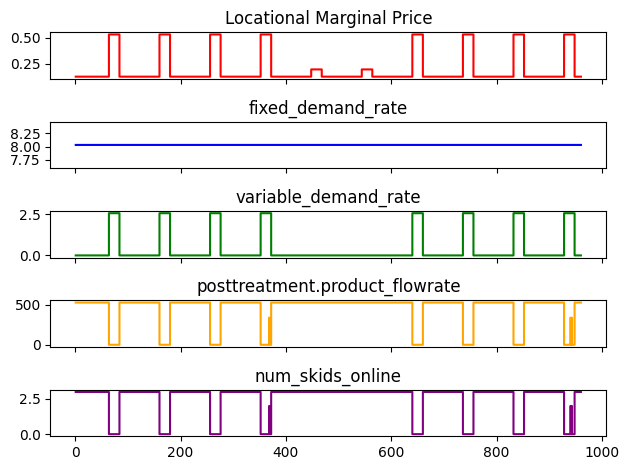

In [13]:
# Write optimal values of all operational variables to a csv file
m.get_operation_var_values().to_csv("dummy_result.csv")

# Plot operational variables
fig, axs = m.plot_operation_profile(
    [
        "fixed_demand_rate",
        "variable_demand_rate",
        "posttreatment.product_flowrate",
        "num_skids_online",
    ],
)

# Return the values of all variables and expressions that do not vary with time
m.get_design_var_values()